# MNIST 图片识别模型
本笔记本使用 PyTorch 框架构建一个简单的 MNIST 图片识别模型，并展示结果。

In [35]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [36]:
# 设置设备（GPU或CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

使用设备: cuda


In [37]:
# 定义模型
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.fc(x)

model = MNISTModel().to(device)  # 将模型移动到GPU

In [38]:
# # 定义损失函数和优化器
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# # 训练模型
# epochs = 5
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.to(device), labels.to(device)  # 将数据移动到GPU
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [40]:
# # 测试模型
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)  # 将数据移动到GPU
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print(f'测试集准确率: {100 * correct / total:.2f}%')

In [46]:
# 添加 CNN 和 ViT 模型的实现

# 定义改进的 CNN 模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # 添加批归一化
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  # 添加批归一化
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 添加额外卷积层
            nn.ReLU(),
            nn.BatchNorm2d(128),  # 添加批归一化
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),  # 调整全连接层输入大小
            nn.ReLU(),
            nn.Dropout(0.5),  # 添加Dropout防止过拟合
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# 定义 ViT 模型
from torchvision.models.vision_transformer import vit_b_16
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.vit = vit_b_16(pretrained=False, num_classes=10)

    def forward(self, x):
        return self.vit(x)

# 训练和测试函数
def train_and_evaluate(model, train_loader, test_loader, epochs=50):
    model = model.to(device)  # 将模型移动到GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # 将数据移动到GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'模型 {type(model).__name__} - Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # 测试模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # 将数据移动到GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# 对比三种模型
print("开始训练和评估三种不同的模型...")

# 准备对MNIST数据集适用的更小的ViT模型
class TinyViT(nn.Module):
    def __init__(self):
        super(TinyViT, self).__init__()
        # ViT需要3通道输入，我们需要将MNIST单通道图像转换为3通道
        self.process = nn.Conv2d(1, 3, kernel_size=1)
        # 使用更小的ViT配置
        self.patch_size = 4  # 使用更小的patch size
        self.image_size = 28  # 使用原始MNIST尺寸，避免插值
        # 计算序列长度 (28/4)^2 = 49
        num_patches = (self.image_size // self.patch_size) ** 2
        # 使用较小的embedding维度
        embed_dim = 64
        num_heads = 2
        num_layers = 2
        # 嵌入层 (从patches到embed_dim)
        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=self.patch_size, stride=self.patch_size),
            nn.Flatten(2)
        )
        # 位置编码
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Transformer编码器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads,
            dim_feedforward=embed_dim * 2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # 分类头
        self.head = nn.Linear(embed_dim, 10)
    def forward(self, x):
        # 1x28x28 -> 3x28x28
        x = self.process(x)
        # 嵌入patches
        x = self.patch_embed(x)

        # 手动执行维度交换，替代nn.Permute(0, 2, 1)
        x = x.permute(0, 2, 1)

        # 添加分类token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        # 添加位置编码
        x = x + self.pos_embed
        # Transformer编码
        x = self.transformer(x)
        # 使用CLS token进行分类
        x = self.head(x[:, 0])
        return x

mlp_model = MNISTModel()
cnn_model = CNNModel()
vit_model = TinyViT()  # 使用更小的ViT模型

# 使用更小的批次大小来防止GPU内存不足，但由于模型更小，可以适当增加
batch_size = 64
train_loader_small = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_small = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print("训练MLP模型...")
# mlp_accuracy = train_and_evaluate(mlp_model, train_loader_small, test_loader_small)

print("训练CNN模型...")
cnn_accuracy = train_and_evaluate(cnn_model, train_loader_small, test_loader_small)

# print("训练TinyViT模型...")
# vit_accuracy = train_and_evaluate(vit_model, train_loader_small, test_loader_small)

print("\n最终结果对比:")
# print(f"MLP 测试集准确率: {mlp_accuracy:.2f}%")
print(f"CNN 测试集准确率: {cnn_accuracy:.2f}%")
# print(f"TinyViT 测试集准确率: {vit_accuracy:.2f}%")

开始训练和评估三种不同的模型...
训练CNN模型...
模型 CNNModel - Epoch 1/50, Loss: 0.1116
模型 CNNModel - Epoch 2/50, Loss: 0.0473
模型 CNNModel - Epoch 3/50, Loss: 0.0397
模型 CNNModel - Epoch 4/50, Loss: 0.0304
模型 CNNModel - Epoch 5/50, Loss: 0.0272
模型 CNNModel - Epoch 6/50, Loss: 0.0266
模型 CNNModel - Epoch 7/50, Loss: 0.0209
模型 CNNModel - Epoch 8/50, Loss: 0.0220
模型 CNNModel - Epoch 9/50, Loss: 0.0189
模型 CNNModel - Epoch 10/50, Loss: 0.0173
模型 CNNModel - Epoch 11/50, Loss: 0.0169
模型 CNNModel - Epoch 12/50, Loss: 0.0139
模型 CNNModel - Epoch 13/50, Loss: 0.0158
模型 CNNModel - Epoch 14/50, Loss: 0.0137
模型 CNNModel - Epoch 15/50, Loss: 0.0141
模型 CNNModel - Epoch 16/50, Loss: 0.0132
模型 CNNModel - Epoch 17/50, Loss: 0.0118
模型 CNNModel - Epoch 18/50, Loss: 0.0123
模型 CNNModel - Epoch 19/50, Loss: 0.0086
模型 CNNModel - Epoch 20/50, Loss: 0.0113
模型 CNNModel - Epoch 21/50, Loss: 0.0104
模型 CNNModel - Epoch 22/50, Loss: 0.0136
模型 CNNModel - Epoch 23/50, Loss: 0.0081
模型 CNNModel - Epoch 24/50, Loss: 0.0090
模型 CNNModel - Epoch 

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

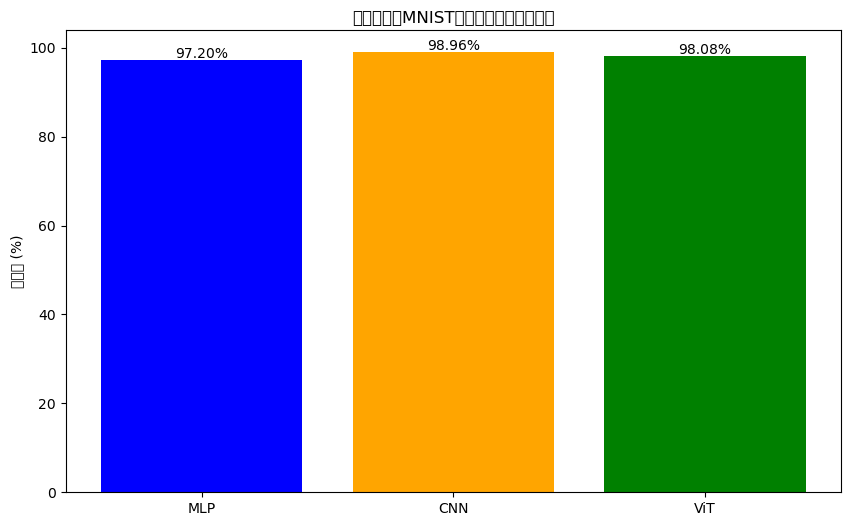

In [45]:
# 可视化结果
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
models = ["MLP", "CNN", "ViT"]
accuracies = [mlp_accuracy, cnn_accuracy, vit_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.ylabel('准确率 (%)')
plt.title('不同模型在MNIST数据集上的准确率对比')
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.5, f'{acc:.2f}%', ha='center')
plt.show()